<a href="https://colab.research.google.com/github/aaronjoel/DeepUnderstandingOfDeepLearning/blob/main/DUDL_MeasurePerformance_Example_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# NEW!
import sklearn.metrics as skm

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as mb
mb.set_matplotlib_formats('svg')

## Import and process the data

In [103]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:, 0]
data   = data[:, 1:]

# normalize the data to a range of [0 1]
dataNorm = (data - data.min()) / (data.max() - data.min())

dataNorm2 = (data - np.min(data)) / (np.max(data) - np.min(data))

In [104]:
dataNorm.all() == dataNorm2.all()

np.True_

In [105]:
# Step 1: convert to tensor
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()


dataT.shape, labelsT.shape

(torch.Size([20000, 784]), torch.Size([20000]))

In [106]:
# Step 2:use scikit-learn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=.15, random_state=42)

In [107]:
train_data.shape, test_data.shape

(torch.Size([17000, 784]), torch.Size([3000, 784]))

In [108]:
# Step 3: convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data, train_labels)
test_data  = torch.utils.data.TensorDataset(test_data, test_labels)

In [109]:
# Step 4: translate into dataloader objects
batch_size = 32
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader  = DataLoader(dataset=test_data, batch_size=test_data.tensors[0].shape[0])

## Create the DL model

In [110]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      # input layer
      self.input = nn.Linear(784, 64)

      # hidden layer
      self.fc1 = nn.Linear(64, 32)
      self.fc2 = nn.Linear(32, 32)

      # output layer
      self.output = nn.Linear(32, 10)

    def forward(self, x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      x = self.output(x)
      return x

  # create the model instance
  net = mnistNet()

  # loss function
  loss_fun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(), lr=.01)

  return net, loss_fun, optimizer

## Create a function that trains the model

In [111]:
def function2trainTheModel(num_epochs=5):
  # create a new model
  net, loss_fun, optimizer = createTheMNISTNet()

  # initialize losses
  losses   = torch.zeros(num_epochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epoch in range(num_epochs):
    # loop over training data batches
    batchAcc = []
    batchLoss = []
    for X, y in train_loader:
      # forward pass and loss
      yhat = net(X)
      loss = loss_fun(yhat, y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yhat, axis=1) == y    # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epoch] = np.mean(batchLoss)

    # test accuracy
    X, y = next(iter(test_loader)) # extract X, y from test dataloader
    with torch.no_grad():  # deactivates autograd
      yhat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean( (torch.argmax(yhat, axis=1) == y).float() ) )

  # end epochs

  # function output
  return trainAcc, testAcc, losses, net

## Run the model and show the results!

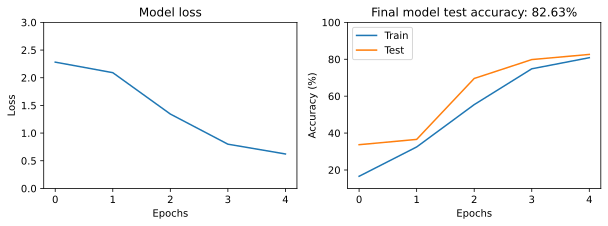

In [112]:
# build and train the model
trainAcc, testAcc, losses, net = function2trainTheModel(num_epochs=5)


# visualization start here
fig, ax = plt.subplots(1, 2, figsize=(10, 3))


ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title('Model loss')


ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10, 100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

## Compute the performance measures on the train and test data

In [113]:
# predicted digits for training data
yhat = net(train_loader.dataset.tensors[0])
yhat.shape

torch.Size([17000, 10])

In [114]:
train_predictions = torch.argmax(yhat, axis=1)
train_predictions.shape

torch.Size([17000])

In [115]:
yhat[0]

tensor([-4.0453, -1.8889,  4.9265,  0.7513, -1.1664,  0.7801,  0.3544, -6.4091,
         4.6247, -2.3793], grad_fn=<SelectBackward0>)

In [116]:
yhat.argmax(axis=1)

tensor([2, 6, 0,  ..., 9, 2, 7])

In [117]:
yhat[0].argmax()

tensor(2)

In [118]:
# predictions for test data
yhat = net(test_loader.dataset.tensors[0])
test_predictions = torch.argmax(yhat, axis=1)
test_predictions.shape

torch.Size([3000])

In [119]:
test_predictions[:10]

tensor([9, 5, 2, 2, 6, 0, 0, 0, 9, 5])

In [120]:
yhat[0].argmax()

tensor(9)

In [121]:
# Brief aside on computing precision et al. in multiclass data:
# There are now 10 classes, so there are 10 precision values.

## option 1: compute precision for each class (each number)
skm.precision_score(train_loader.dataset.tensors[1], train_predictions, average=None)

array([0.85036702, 0.91573034, 0.77229489, 0.85670545, 0.77747845,
       0.73032952, 0.88682432, 0.88733154, 0.77032258, 0.84078212])

In [122]:
## option 2: compute average precision, weighted by N
skm.precision_score(train_loader.dataset.tensors[1], train_predictions, average='weighted')

0.8316273701074436

In [123]:
skm.precision_score(train_loader.dataset.tensors[1], train_predictions, average=None).mean()#

np.float64(0.8288166233556911)

In [124]:
## option 3: compute average precision, unweighted (same as 'weighted' if category N's are equal)
skm.precision_score(train_loader.dataset.tensors[1], train_predictions, average='macro')

0.8288166233556911

In [125]:
# initialise vectors
train_metrics = [0, 0, 0, 0]
test_metrics  = [0, 0, 0, 0]

# training
train_metrics[0] = skm.accuracy_score (train_loader.dataset.tensors[1], train_predictions) # accuracy is overall
train_metrics[1] = skm.precision_score(train_loader.dataset.tensors[1], train_predictions, average='weighted')
train_metrics[2] = skm.recall_score   (train_loader.dataset.tensors[1], train_predictions, average='weighted')
train_metrics[3] = skm.f1_score       (train_loader.dataset.tensors[1], train_predictions, average='weighted')

# testing
test_metrics[0]  = skm.accuracy_score (test_loader.dataset.tensors[1], test_predictions)
test_metrics[1]  = skm.precision_score(test_loader.dataset.tensors[1], test_predictions, average='weighted')
test_metrics[2]  = skm.recall_score   (test_loader.dataset.tensors[1], test_predictions, average='weighted')
test_metrics[3]  = skm.f1_score       (test_loader.dataset.tensors[1], test_predictions, average='weighted')

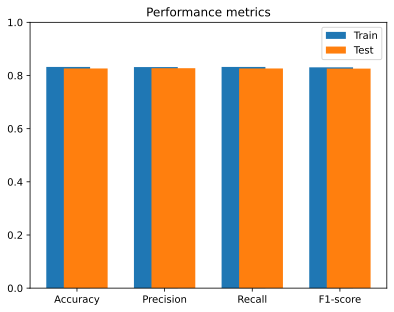

In [126]:
plt.bar(np.arange(4)-.1, train_metrics, .5)
plt.bar(np.arange(4)+.1, test_metrics, .5)
plt.xticks([0, 1, 2, 3], ['Accuracy', 'Precision', 'Recall', 'F1-score'])
plt.ylim([0, 1])
plt.legend(['Train', 'Test'])
plt.title('Performance metrics')
plt.show()

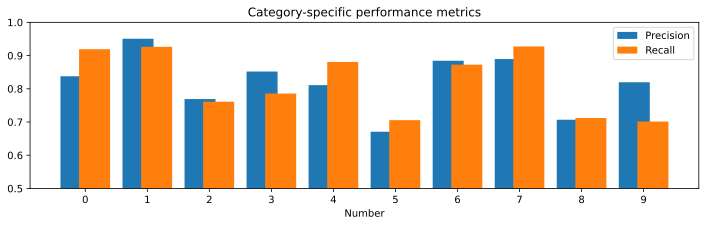

In [127]:
# Bar graphs of class-specific precision and recall for test data
precision = skm.precision_score(test_loader.dataset.tensors[1], test_predictions, average=None)
recall    = skm.recall_score(test_loader.dataset.tensors[1], test_predictions, average=None)

fig = plt.figure(figsize=(12, 3))

plt.bar(np.arange(10)-.15, precision, .5)
plt.bar(np.arange(10)+.15, recall, .5)

plt.xticks(range(10), range(10))
plt.ylim([.5, 1])
plt.xlabel('Number')
plt.legend(['Precision', 'Recall'])
plt.title('Category-specific performance metrics')
plt.show()

In [128]:
precision

array([0.83775811, 0.9505814 , 0.76896552, 0.85185185, 0.81097561,
       0.67078189, 0.88435374, 0.88953488, 0.70676692, 0.81960784])

In [129]:
recall

array([0.91909385, 0.92634561, 0.76109215, 0.78571429, 0.8807947 ,
       0.70562771, 0.87248322, 0.92727273, 0.71212121, 0.70134228])

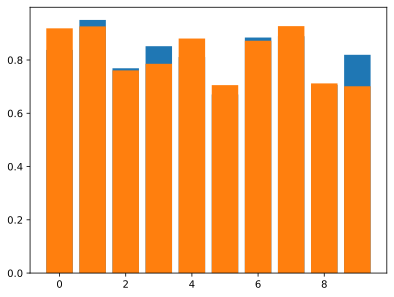

In [130]:
plt.bar(range(10), precision)
plt.bar(range(10), recall);

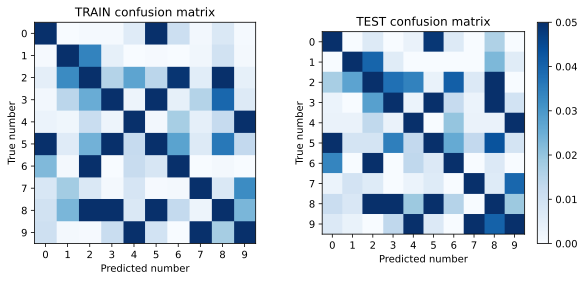

In [131]:
# Confusion matrices
trainConf = skm.confusion_matrix(train_loader.dataset.tensors[1],train_predictions,normalize='true')
testConf  = skm.confusion_matrix(test_loader.dataset.tensors[1], test_predictions,normalize='true')

fig,ax = plt.subplots(1,2,figsize=(10,4))

# confmat during TRAIN
ax[0].imshow(trainConf,'Blues',vmax=.05)
ax[0].set_xticks(range(10))
ax[0].set_yticks(range(10))
ax[0].set_title('TRAIN confusion matrix')
ax[0].set_xlabel('True number')
ax[0].set_xlabel('Predicted number')
ax[0].set_ylabel('True number')

# confmat during TEST
a = ax[1].imshow(testConf,cmap='Blues',vmax=.05)
ax[1].set_xticks(range(10))
ax[1].set_yticks(range(10))
ax[1].set_title('TEST confusion matrix')
ax[1].set_xlabel('Predicted number')
ax[1].set_ylabel('True number')

fig.colorbar(a)
plt.show()

In [132]:
# Confusion matrices
trainConf = skm.confusion_matrix(train_loader.dataset.tensors[1], train_predictions, normalize='true')
trainConf

array([[9.11070780e-01, 0.00000000e+00, 6.04960678e-04, 6.04960678e-04,
        6.04960678e-03, 6.17059891e-02, 1.08892922e-02, 1.20992136e-03,
        7.25952813e-03, 6.04960678e-04],
       [5.29100529e-04, 9.48677249e-01, 3.38624339e-02, 4.23280423e-03,
        0.00000000e+00, 5.29100529e-04, 0.00000000e+00, 1.58730159e-03,
        9.52380952e-03, 1.05820106e-03],
       [4.71698113e-03, 3.24292453e-02, 7.65919811e-01, 1.53301887e-02,
        2.71226415e-02, 1.41509434e-02, 4.89386792e-02, 5.30660377e-03,
        8.19575472e-02, 4.12735849e-03],
       [1.17716304e-03, 1.41259564e-02, 2.53090053e-02, 8.23425544e-01,
        2.35432607e-03, 6.82754562e-02, 4.12007063e-03, 1.53031195e-02,
        3.94349617e-02, 6.47439670e-03],
       [3.08261406e-03, 1.84956843e-03, 1.17139334e-02, 2.46609125e-03,
        8.89642417e-01, 1.23304562e-03, 1.72626387e-02, 4.31565968e-03,
        1.23304562e-02, 5.61035758e-02],
       [1.05882353e-01, 5.88235294e-03, 2.41830065e-02, 5.88235294e-02,
   

In [133]:
trainConf.shape

(10, 10)

In [134]:
testConf = skm.confusion_matrix(test_loader.dataset.tensors[1], test_predictions, normalize='true')
testConf

array([[0.91909385, 0.        , 0.00647249, 0.        , 0.00323625,
        0.04854369, 0.00647249, 0.        , 0.01618123, 0.        ],
       [0.        , 0.92634561, 0.03966006, 0.00566572, 0.        ,
        0.        , 0.        , 0.        , 0.02266289, 0.00566572],
       [0.01706485, 0.02730375, 0.76109215, 0.03754266, 0.03412969,
        0.00341297, 0.04095563, 0.00682594, 0.07167235, 0.        ],
       [0.00310559, 0.        , 0.02795031, 0.78571429, 0.00310559,
        0.10248447, 0.01242236, 0.00310559, 0.05279503, 0.00931677],
       [0.00331126, 0.00331126, 0.01324503, 0.00331126, 0.8807947 ,
        0.        , 0.01986755, 0.00331126, 0.00331126, 0.06953642],
       [0.13852814, 0.00865801, 0.00865801, 0.03463203, 0.01298701,
        0.70562771, 0.02597403, 0.01298701, 0.04329004, 0.00865801],
       [0.03355705, 0.        , 0.06711409, 0.        , 0.01342282,
        0.00671141, 0.87248322, 0.        , 0.00671141, 0.        ],
       [0.0030303 , 0.00909091, 0.0060606

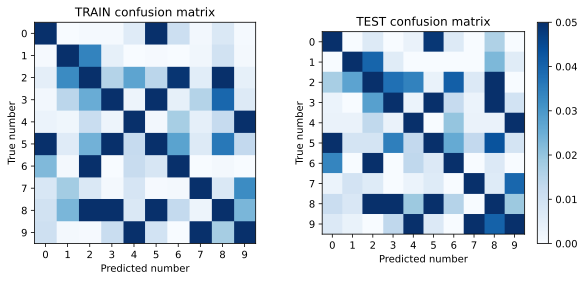

In [135]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))


ax[0].imshow(trainConf, 'Blues', vmax=.05)
ax[0].set_xticks(range(10))
ax[0].set_yticks(range(10))
ax[0].set_title('TRAIN confusion matrix')
ax[0].set_xlabel('Predicted number')
ax[0].set_ylabel('True number')

# confmat during TEST
a = ax[1].imshow(testConf, cmap='Blues', vmax=.05)
ax[1].set_xticks(range(10))
ax[1].set_yticks(range(10))
ax[1].set_title('TEST confusion matrix')
ax[1].set_xlabel('Predicted number')
ax[1].set_ylabel('True number')

fig.colorbar(a)
plt.show()

In [136]:
# 1) The Adam optimizer is pretty amazing, isn't it? Change the code to get the overall test accuracy between 50% and 80%.
#    You can consider changing the optimizer, learning rate, and number of epochs. Then show the performance metrics.
#    Are there systematic difficulties with some numbers, or simply a general decline in performance overall?
#
# 2) Are the y-axis and color-limits still appropriate? Modify the visualization code so that the graphs are adaptive
#    to the numerical values of the performance metrics and confusion matrices.
#